In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
from numpy import s_
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
from collections import defaultdict
import metpy
import metpy.calc as mpcalc
from metpy.units import units
from scipy.interpolate import griddata
from datetime import datetime
import pandas as pd
import dask

# Read bathymetry dataset

# Read radar datasets

In [2]:
def path_to_radar_ds(radar_site_no):
    list = ["202201","202202","202101","202102","202103","202104","202001","202002","202003","202004","201901","201902","201903","201904",
           "201801","201802","201803","201804","201701","201702","201703","201704","201601","201602","201603","201604","201501","201502",
           "201503","201504","201401","201402","201403","201404","201301","201302","201303","201304","201201","201202","201203","201204",
          ] # 202203 and 202204 removed since not in radar data; radar data goes back to 08-2011
    files_list = []
    for i in list:
        fp = "/g/data/rq0/level_2/"+radar_site_no+"/RAINRATE/"
        all_files = [os.path.join(root, f) for root, _, files in os.walk(fp)
            for f in files
            if f.startswith(radar_site_no+'_'+i) and f.endswith('.nc')]
        files_list.extend(all_files)
    files_list.sort()
    return files_list

towns_radar_files = path_to_radar_ds("73")
cairns_radar_files = path_to_radar_ds("19")
willis_radar_files = path_to_radar_ds("41")

In [30]:
def read_netcdf(file_path,bb=None):
    with xr.open_mfdataset(file_path) as ds:
        # Perform any processing on the dataset
        mask = ds.rainrate.where(~ds.rainrate.isnull()) 
        mean_rr = mask.mean(dim='time')
        if bb==True:
            masked_beam_blockage = xr.where((mean_rr < 1.2), np.nan,mean_rr) # 1.2 for cairns, 0.8 for townsville
            mask_ds = ds.rainrate.where(~masked_beam_blockage.isnull()) 
        else:
            mask_ds = ds.rainrate.where(~mean_rr.isnull()) 
        
        # For example, compute mean of a variable
        result = mask_ds.fillna(0) #mask_ds, fill nans (times with no rain) as zeros
    return result

In [31]:
cairns_rr = read_netcdf(cairns_radar_files,bb=False)

In [72]:
import scripts.radar_calc_missing_data as calc_missing_radar_data

In [73]:
help(calc_missing_radar_data)

Help on module scripts.radar_calc_missing_data in scripts:

NAME
    scripts.radar_calc_missing_data

FILE
    /home/563/ac9768/scripts/radar_calc_missing_data.py




In [63]:
missing,exists,times = calc_missing_radar_data.missing_data_netcdf(towns_radar_files)

AttributeError: module 'scripts.radar_calc_missing_data' has no attribute 'missing_data_netcdf'

In [46]:
def missing_data_netcdf(file_path):
    with xr.open_mfdataset(file_path) as ds:
        missing = ds.isfile.where(ds.isfile==0)
        nonmissing = ds.isfile.where(ds.isfile==1)
    return missing.count(),nonmissing.count(),ds.time.count()

In [44]:
missing,exists,times = missing_data_netcdf(towns_radar_files)
print(exists.values)
print(missing.values)
times

In [25]:
cairns=xr.open_dataset(cairns_radar_files[8])

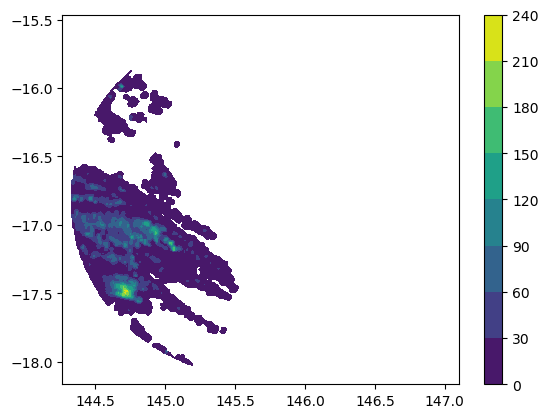

In [26]:
plt.contourf(cairns.longitude,cairns.latitude,cairns.rainrate.mean(dim="time"))
plt.colorbar()

In [35]:
def him8_files(directory):
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith("_ch13BT_regridded_2kmres.nc"):  
                file_paths.append(os.path.join(root, file))
    return file_paths
directory = "/home/563/ac9768/"
files = him8_files(directory)
BT2016=xr.open_dataset(files[0]) 


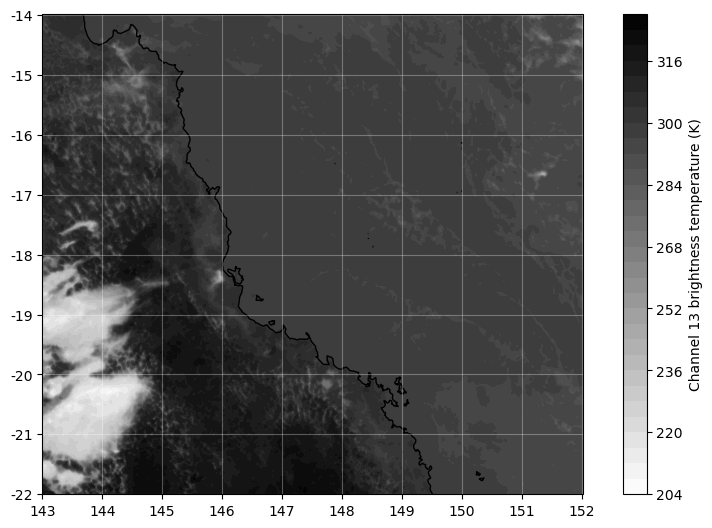

In [58]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8],projection=ccrs.PlateCarree())
ax.coastlines()
bt = ax.contourf(BT2016.lon,BT2016.lat,BT2016.ch13BT.isel(time=5),levels=30,cmap="binary")
plt.colorbar(bt,label="Channel 13 brightness temperature (K)")
ax.set_xticks([143,144,145,146,147,148,149,150,151,152])
ax.set_xticklabels([143,144,145,146,147,148,149,150,151,152])
ax.set_yticks([-22,-21,-20,-19,-18,-17,-16,-15,-14])
ax.set_yticklabels([-22,-21,-20,-19,-18,-17,-16,-15,-14])
ax.grid(True,color="white",alpha=0.3)